# Numerical Experiments

##### Code Init

In [31]:
# Function file import
import functionfile_speedygreedy as ff

## Experiment Overview

Experiment parameters are created in *experiment_parameters.csv* (works with MS Excel)

### Parameters:
- ***experiment_no*** : Ensure that every new row has a new number to prevent data overwrites
- ***test_model*** and ***test_parameter***: These define the experiment model and control parameter

| Exp No | test_model                                        | Test Description                                                                                                                                                                                                                               | *test_parameter* Effect                                                                                                                                                                                             |
|:------:|:--------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  1.1   | *fixed_vs_self_tuning*                            | compare fixed architecture to self-tuning architecture for a generated network                                                                                                                                                                 | number of changes permitted for self_tuning architecture $N=$*test_parameter*                                                                                                                                       |
|  1.2   | *statistics_fixed_vs_self_tuning*                 | run fixed_vs_self_tuning for 100 different randomly generated network graphs                                                                                                                                                                   | number of changes permitted for self_tuning architecture $N=$*test_parameter*                                                                                                                                       |
|  1.3   | *statistics_pointdistribution_openloop*           | run fixed_vs_self_tuning over initial points on eigenvectors of open-loop dynamics matrix of a single instance of a randomly generated network                                                                                                 | number of changes permitted for self_tuning architecture $N=$*test_parameter*                                                                                                                                       |
|  2.1   | *self_tuning_number_of_changes*                   | compare the effect of 1 vs $n$ number of architecture optimization changes allowed per simulation step                                                                                                                                         | number of changes permitted for self_tuning architecture $N\rightarrow\infty$ vs $N=$*test_parameter*                                                                                                               |
|  2.2   | *statistics_self_tuning_number_of_changes*        | run self_tuning_number_of_changes for 100 different randomly generated network graphs                                                                                                                                                          | number of changes permitted for self_tuning architecture $N\rightarrow\infty$ vs $N=$*test_parameter*                                                                                                               |
|  3.1   | *self_tuning_prediction_horizon*                  | compare the effect of scaling prediction time horizon                                                                                                                                                                                          | scales the base time horizon $T_p$ vs $T_p$ * *test_parameter*                                                                                                                                                      |
|  3.2   | *statistics_self_tuning_prediction_horizon*       | run self_tuning_prediction_horizon for 100 different randomly generated network graphs                                                                                                                                                         | scales the base time horizon $T_p$ vs $T_p$ * *test_parameter*                                                                                                                                                      | 
|  4.1   | *self_tuning_architecture_cost_no_lim*            | compare the effect of scaling architecture running and switching costs with unbounded changes per swap iteration $N\rightarrow\infty$ and loose architecture constraints $\mathcal{L}_m = \mathcal{L}_{m'} < \mathcal{L}_M = \mathcal{L}_{M'}$ | scales the base architecture costs  $R_{2,\mathcal{B}}, R_{2,\mathcal{C}}, R_{3,\mathcal{B}}, R_{3,\mathcal{C}}$ vs *test_parameter* * $R_{2,\mathcal{B}}, R_{2,\mathcal{C}}, R_{3,\mathcal{B}}, R_{3,\mathcal{C}}$ |
|  4.2   | *self_tuning_architecture_constraints*            | compare the effect of tight vs loose architecture constraints on self-tuning architecture under constant running + switching costs                                                                                                             | changes lower bound on active architecture sets $[\mathcal{L}_{m}, \mathcal{L}_{m'}]$ vs $[$ *test_parameter*, *test_parameter* $]$                                                                                 |
|  4.3   | *statistics_self_tuning_architecture_cost_no_lim* | run *self_tuning_architecture_cost_no_lim* for 100 different randomly generated network graphs                                                                                                                                                 | scales the base architecture costs $R_{2,\mathcal{B}}, R_{2,\mathcal{C}}, R_{3,\mathcal{B}}, R_{3,\mathcal{C}}$ vs *test_parameter* * $R_{2,\mathcal{B}}, R_{2,\mathcal{C}}, R_{3,\mathcal{B}}, R_{3,\mathcal{C}}$  |
|  4.4   | *statistics_self_tuning_architecture_constraints* | run *self_tuning_architecture_constraints* for 100 different randomly generated network graphs                                                                                                                                                 | changes lower bound on active architecture sets $[\mathcal{L}_{m}, \mathcal{L}_{m'}]$ vs $[$ *test_parameter*, *test_parameter* $]$                                                                                 |

- Network generation parameters:
    - ***number_of_nodes*** : number of nodes in the network model
    - ***network_model*** : type of network connection - generated using *numpy* and *networkx* packages
        - *rand* : random weighted adjacency matrix with weights $[0,1)$
        - *ER* : a realization of an Erdos-Renyi random graph generator with edge probability $p$
        - *BA* : generate a realization of a Barabasi-Albert random graph generator with initial seed $p$
        - *path* : generate a path graph
        - *cycle* : generate a cycle graph
        - *eval_squeeze* : generate spectrum of eigenvalues in $(-1-p, -1+p) \cup (1-p, 1+p)$ to force stable modes with slow convergence and unstable modes with slow divergence
        - *eval_bound* : generate spectrum of eigenvalues in $(-1, -1+p) \cup (1-p, 1)$ to force stable modes with slow convergence
        All graphs are checked to be well-connected, i.e., there are no isolated subnetworks and there is a path (direct or indirect) between every pair of nodes
        For *eval_squeeze* and *eval_bound*, the underlying eigenvectors are randomly generated and normalized. All nodes have a self-connecting edge before uniform scaling is enforced 
    - ***network_parameter*** : generation parameter for ER, BA, eval_squeeze and eval_bound generators
    - ***rho*** : uniform scaling parameter to apply to adjacency matrix if required
    - ***second_order*** and ***second_order_network*** : specify if network nodes have second-order dynamics and which level is connected by the network adjacency $G_{adj}$
        Dynamics of the $i^{th}$ node is given by $x'_{i,t}$ and $x_{i,t}$
        - If not *second_order*, then *number_of_states* $n=$ *number_of_nodes*
        - If *second_order*, then *number_of_states* $n=2$ * *number_of_nodes*
        Open-loop dynamics based on *second_order_network* parameter for states $x_t = \begin{bmatrix} \dots x_{i,t} \dots x'_{i,t} \dots \end{bmatrix}^\top$: 
        - *second_order_network* = 1 : $A = \begin{bmatrix} G_{adj} & \mathbf{0} \\ \mathbf{I} & \mathbf{I} \end{bmatrix}$ where network dynamics affects $x_{i,t}$ and $x'_{i,t+1} = x'_{i,t} + x_{i,t}$
        - *second_order_network* = 2 : $A = \begin{bmatrix} \mathbf{I} & \mathbf{0} \\ \mathbf{I} & G_{adj} \end{bmatrix}$ where network dynamics affects $x'_{i,t}$  and $x'_{i,t+1} = x'_{i,t} + x_{i,t} + \sum_{j\in\mathscr{N}(x_i)}G_{adj,i,j}x_j$
- Architecture parameters: Applicable for both actuators and sensors
    Initializes available architecture as identity basis vectors of $\mathbb{R}^n$ space
    - ***initial_architecture_size*** : size of initial randomly placed or design-time optimized architecture $|S_{t=0}|, |S_{t=0}|$
    - ***architecture_constraint_min***, ***architecture_constraint_max*** : min $\mathcal{L}_m, \mathcal{L}_{m'}$ and max $\mathcal{L}_M, \mathcal{L}_{M'}$ constraints on the size of the architecture sets. Set equal to each other for constrained optimization
    - ***second_order_architecture*** : needs to be defined if second-order network dynamics for actuator inputs and sensor measurements
        - *second_order_architecture* = 1 : architecture connected to $x_{i,t}$ nodes
        - *second_order_architecture* = 2 : architecture connected to $x'_{i,t}$ nodes
    - ***Q_cost_scaling***, ***R_cost_scaling*** : scaling costs on states and inputs for control objective - default 1 is identity
        - $Q_\mathcal{B} = \mathbf{I}_{n}$ * *Q_cost_scaling*
        - $R_{1,|\mathcal{B}|} = \mathbf{I}_{|\mathcal{B}|}$ * *R_cost_scaling* : assumes submatrix $R_{1,|S_t|}$ of suitable dimension imposes identical input costs on all active actuators $S_t$
    - ***B_run_cost***, ***C_run_cost*** : vector of uniform architecture running costs for actuators and sensors respectively
        - Actuator running costs: $R_{2,\mathcal{B}} = \mathbf{1}_{|\mathcal{B}|}$ * *B_run_cost*
        - Sensor running costs: $R_{2,\mathcal{C}} = \mathbf{1}_{|\mathcal{C}|}$ * *C_run_cost*
    - ***B_switch_cost***, ***C_switch_cost*** : vector of uniform architecture switching costs for actuators and sensors respectively
        - Actuator switching costs: $R_{3,\mathcal{B}} = \mathbf{1}_{|\mathcal{B}|}$ * *B_switch_cost*
        - Sensor switching costs: $R_{3,\mathcal{C}} = \mathbf{1}_{|\mathcal{C}|}$ * *C_switch_cost*
- Disturbance parameters: additive process/measurement noise and un-modelled disturbance generators
    - ***W_scaling*** : scaling of identity matrix on covariance of zero-mean process noise
    - ***V_scaling*** : scaling of identity matrix on covariance of zero-mean measurement noise - dimension affected by number of active sensors $|S'_t|$
        Note that *W_scaling* and *V_scaling* are parameters of estimation optimization
        - Process noise $w_t \sim \mathcal{N}(\mathbf{0}_n, \mathbf{I}_n$ * *W_scaling* $)$
        - Measurement noise $v_t \sim \mathcal{N}(\mathbf{0}_{|S'_t|}, \mathbf{I}_{|S'_t|}$ * *V_scaling* $)$
    - ***disturbance_model*** : type of un-modelled noise model
        - *process* - additional noise only in process
        - *measurement* - additional noise only in measurement
        - *combined* - additional noise in both process and measurement
    - ***disturbance_step***, ***disturbance_number***, ***disturbance_magnitude*** : how frequently, at which random states and how large the randomly generated un-modelled noise enters the process and measurements
        - *process* noise $w_t$ for $n_k={n \choose \textit{disturbance_number}$ random states
        - *measurement* noise $v_t$ for all active sensor outputs
            $w_{t=i*\textit{disturbance_step}, n_k} = \pm \textit{disturbance_magnitude}$
            $v_{t=i*\textit{disturbance_step}} = \pm\textit{disturbance_magnitude}$

- Simulation parameters:
    - ***prediction_time_horizon*** : $T_p$ length of the (MPC-like) receding prediction horizon over which architecture is assumed to be constant and optimized for
    - ***X0_scaling*** : uniform scaling parameter of the identity covariance matrix of zero-mean distribution of initial state and initial state estimate
        - $x_0, \hat{x}_0 \sim \mathcal{N}(\mathbf{0}_{n}, \mathbf{I}_n$ * *X0_scaling* $)$
        - If *test_model* is *statistics_pointdistribution_openloop*
            $x_0 = V_i$ * *X0_scaling* for i$^{th}$ orthonormal eigenvector of dynamics $A$
    - ***multiprocessing*** : default set to **True** for *statistics* experiments uses *concurrent.futures.ProcessPoolExecutor()* to run statistical experiments for different models/tests in parallel 

# Run + Plot Instructions

Define the experiment parameters in experiment_parameters.csv and set corresponding experiment number to *exp_no*

<span style="color:red;">WARNING: Check for unique experiment numbers to prevent overwriting data.</span>
Default Flags: *run_flag, plot_flag = False, True*
Set *run_flag = True* to regen data and run simulation from scratch
Note that most test cases of a single realization may take 5 - 10 minutes, statistical cases may take 10-20 hours with the *multiprocessing* parameter set to **True** 

#### Code Flags

In [32]:
run_flag = False    # Uses pre-generated model data from DataDump folder
# run_flag = True   # Simulates experiment and saves data to DataDump folder for plotting

plot_flag = True   # Plots data for exp_no in DataDump folder

# Numerical Analysis and Experiment Summary

## Exp No 1
### 1.1: Fixed vs Self-tuning Architecture
#### Experiment setup
$50$-node undirected, uniformly weighted graph with open-loop dynamics $A = V \textbf{diag}(\Lambda) V^\top$ where $V \in \mathbf{R}^{50\times 50}$ have orthnormal basis columns and $\Lambda$ is a vector of the eigenvalues of $A$ uniformly distributed close to the unit circle $|\lambda_i (A) - 1| \leq 0.1$ $\forall i \in [1, 2,..., 50]$.
Architecture constrained by $\mathcal{L}_m = \mathcal{L}_M = \mathcal{L}_{m'} = \mathcal{L}_{M'} = 5$ and no running/switching costs
Design-time fixed active architecture set greedy optimized over a $20$-time step prediction horizon
Self-tuning architecture initialized from design-time greedy optimal active set, optimized at each simulation step over a receding $10$-time step prediction horizon, unrestricted $N\rightarrow\infty$ number of iterations with $N^'=2$ changes to active sets per selection/rejection subsequences
#### Code


Plotting Experiment No: 1

Reading sim model: DataDump/sim_model_exp1


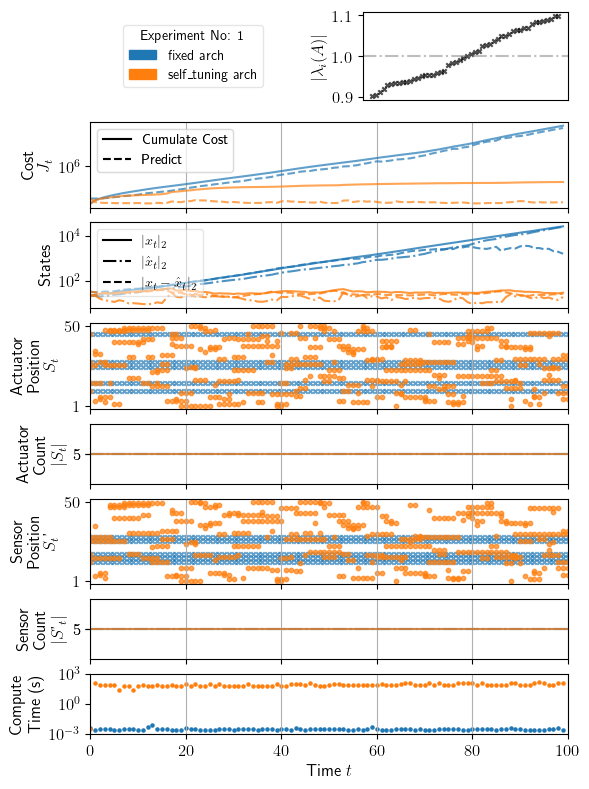


Image saved: Images/exp1.pdf


In [33]:
exp_no = 1
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

#### Discussion
The plot on the top right shows the distribution of the magnitude of the open-loop eigenvalues of the network dynamics. From top to bottom, the plots show the predicted and cumulative true cost, the norms of the true states, state estimates and error vectors, the location and size of the active actuators and sensors, and computation time per simulation time step. In all plots, the blue and orange elements represent the fixed and self-tuning architecture models, respectively.
- Notably, the fixed architecture fails to stabilize the system over the simulation time horizon, whereas the self-tuning architecture attains stability with much lower overall costs.
- From the trajectory plots for the fixed architecture, we can see that the estimation error decreases while the state and state estimate continue to explode. This may indicate an insufficient number of actuators permitted by the actuator constraints. However, the self-tuning architecture compensates for this constraint by optimizing architecture active sets, with tighter stability and error constraints.
- The last plot shows the increased compute time required at each iteration to optimize self-tuning architecture.

### 1.2 : Statistics of Fixed vs Self-tuning Architecture for different graphs
#### Experiment setup
Statistics of $100$-iterations of Exp 1.1 where the network graph is completely randomized. This validates the algorithm over a range of network realizations with the same generation parameters. 
#### Plot


Plotting Experiment No: 2


Model ID:   0%|                                                              | 0/50 [00:00<?, ?it/s]

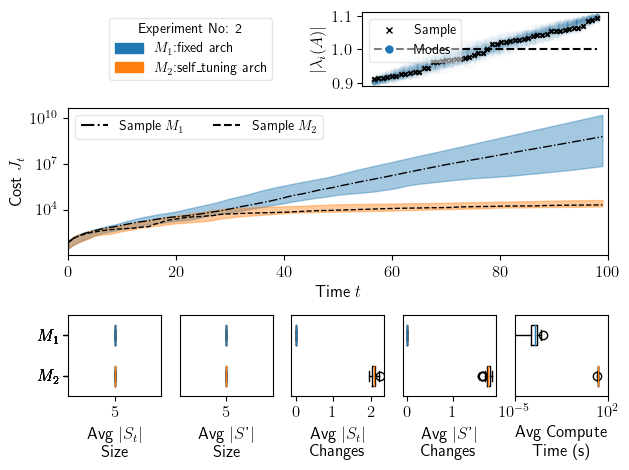


Image saved: Images/exp2.pdf


In [34]:
exp_no = 2
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

#### Discussion
The plot in the top right shows the range of the spectrum of eigenvalues tested.
- The plot in the middle shows the band of cumulative true cost for design-time optimal fixed architecture vs self-tuning optimal architecture. The self-tuning architecture achieves significantly lower and tighter cost bounds.
- The box plots in the bottom row show the time averages of the architecture set size and the number of changes. On average, there are about 2 optimizing changes to the actuator and sensor sets. 

### 1.3 : Statistics of Fixed vs Self-tuning Architecture for state-space exploration
#### Experiment setup
Statistics of $50$-iterations of Exp 1.1 where the network graph is fixed and true state is initialized on the $i^{th}$ eigenvector (i.e. normalized eigenvector or unit vector along the $i^{th}$ eigenvector)
#### Plot


Plotting Experiment No: 3


Model ID:   0%|                                                             | 0/100 [00:00<?, ?it/s]

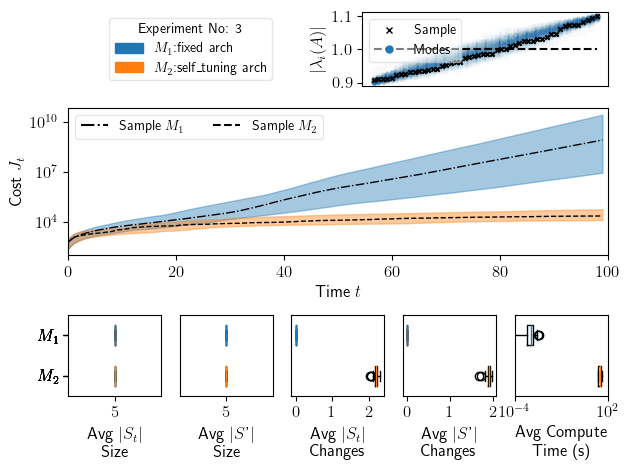


Image saved: Images/exp3.pdf


In [35]:
exp_no = 3
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

#### Discussion
The state-space exploration shows that the self-tuning architecture performs better for initial states along the eigenvectors of the open-loop dynamics and require significant number of changes per timestep.
 

## Discussion Summary for Exp No 1
|         Plot         | Fixed Architecture                                | Self-tuning Architecture                                                                             |
|:--------------------:|:----------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|
|      Cost Plots      | Fails to stabilize the system - predicted and estimated costs increase unbounded                                                                    | Costs converge and system is stabilized within disturbance tolerances                                |
|      Trajectory      | States increase unbounded and relative magnitude of prediction error marginally stabilises - Suggests sufficient sensors and insufficient actuators | States, state estimates and error converges within disturbance tolerances                            |
|     Architecture     | Fixed locations and active set size by problem definition                                                                                           | Fixed active set size by problem definition. Greedy optimal change to architecture at each time step |
|     Compute time     | Only calculates system update parameters at each time step - $ms$/$\mu s$ scale computation                                                        | $\sim 10^1$ seconds per time step to evaluate greedy-optimal architecture                            |

Across all true initial states (and as highlighted by the sample lines), self-tuning architecture consistently performs better than fixed architecture. The tests across the state-space of a network and on different networks reinforce this.


# Exp No 2
## 2.1 : Self-tuning Architecture for number of changes per iteration of the algorithm
### Experiment setup
$50$-node undirected, uniformly weighted graph with dynamics $|\lambda_i (A) - 1| \leq 0.1$ $\forall i \in [1, 2,..., 50]$
Architecture constrained by $\mathcal{L}_m = \mathcal{L}_M = \mathcal{L}_{m'} = \mathcal{L}_{M'} = 5$ and no running/switching costs
Self-tuning architecture initialized from design-time greedy optimal active set, optimized at each simulation step over a receding $10$-time step prediction horizon
Comparison of $N\rightarrow\infty$ (unrestricted) to $N=1$ changes per active set per iteration, both with $N^'=2$ changes to active sets per selection/rejection subsequences
### Plot


Plotting Experiment No: 4

Reading sim model: DataDump/sim_model_exp4


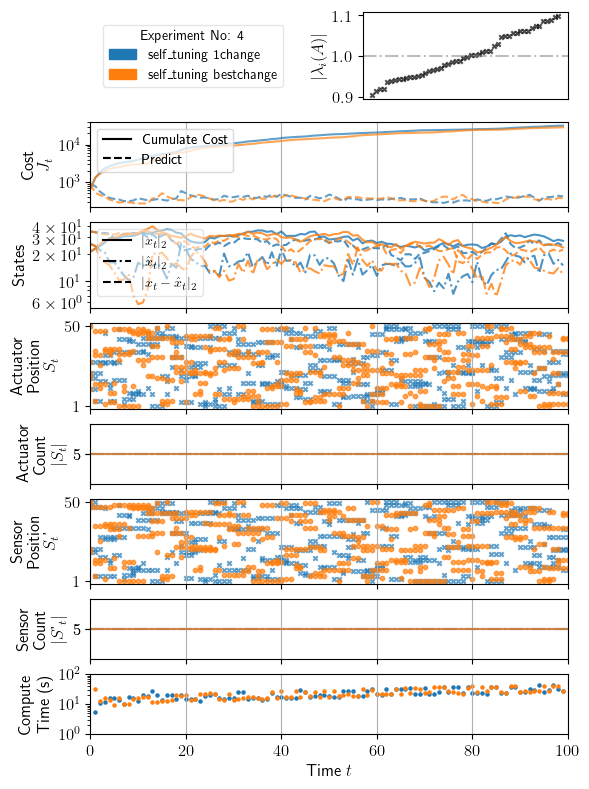

In [ ]:
exp_no = 4
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## 2.2 : Statistics of Self-tuning Architecture for number of changes per iteration of the algorithm
### Experiment setup
Statistics of $100$-iterations of Exp 2.1 where the network graph is completely randomized
### Plot

In [ ]:
exp_no = 5
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## Discussion Summary for Exp No 2
By nature of the greedy algorithm, increasing the number of swapping changes to each architecture from $N=1$ to $N\rightarrow\infty$ has diminishing returns on the improvement of the architecture.
- From both tests, we can see that there are insignificant improvements to the cost and number of changes made from the overlapping cost regions and the comparison of time-average architecture changes.
- Networks with more unstable modes and subject to higher magnitudes of disturbance may see greater benefit from increasing the number of optimization changes.

# Exp No 3
## 3.1 : Self-tuning Architecture for length of prediction horizon
### Experiment setup
$50$-node undirected, uniformly weighted graphs with dynamics $|\lambda_i (A) - 1| \leq 0.1$ $\forall i \in [1, 2,..., 50]$
Architecture constrained by $\mathcal{L}_m = \mathcal{L}_M = \mathcal{L}_{m'} = \mathcal{L}_{M'} = 5$ and no running/switching costs
Self-tuning architecture initialized from design-time greedy optimal active set, optimized at each simulation step over a receding $5$-time step prediction horizon, $N=1$ number of changes per iterations with $N'=1$ change to each active sets per selection/rejection subsequences
Comparison of $T_p=1$ to $5T_p$ changes per active set per iteration, both with $N^'=2$ changes to active sets per selection/rejection subsequences
### Plot

In [ ]:
exp_no = 6
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## 3.2 : Statistics of Self-tuning Architecture for length of prediction horizon
### Experiment setup
Statistics of $100$-iterations of Exp 3.1 where the network graph is completely randomized

In [ ]:
exp_no = 7
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## Discussion Summary for Exp No 3
- A shorter prediction horizon results in more aggressive architecture changes
- For shorter prediction horizons, actuator changes are more preferred than sensor changes to reflect more immediate stabilization errors from accumulated process and estimation noises. 
- For longer prediction horizons, the computation time increases and sensor changes achieve better state estimates for better tracking to minimize control costs.

# Exp No 4
## 4.1 : Self-tuning architecture with running and switching costs
### Experiment setup
$50$-node undirected, uniformly weighted graphs with dynamics $|\lambda_i (A) - 1| \leq 0.1$ $\forall i \in [1, 2,..., 50]$
Self-tuning architecture initialized from design-time greedy optimal active set, optimized at each simulation step over a receding $5$-time step prediction horizon, $N=1$ number of changes per iterations with $N'=1$ change to each active sets per selection/rejection subsequences
Comparison of $T_p=5$ to $2T_p$ changes per active set per iteration, both with $N^'=2$ changes to active sets per selection/rejection subsequences
### Plot

In [ ]:
exp_no = 8
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## 4.2 : Self-tuning architecture with architecture constraints
### Experiment setup
$50$-node undirected, uniformly weighted graphs with dynamics $|\lambda_i (A) - 1| \leq 0.1$ $\forall i \in [1, 2,..., 50]$
Self-tuning architecture initialized from design-time greedy optimal active set, optimized at each simulation step over a receding $5$-time step prediction horizon, $N=1$ number of changes per iterations with $N'=1$ change to each active sets per selection/rejection subsequences
Comparison of $T_p=5$ to $2T_p$ changes per active set per iteration, both with $N^'=2$ changes to active sets per selection/rejection subsequences
### Plot

In [ ]:
exp_no = 9
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## 4.3 : Statistics of Self-tuning architecture with running and switching costs
### Experiment setup
Statistics of $100$-iterations of Exp 3.1 where the network graph is completely randomized

In [ ]:
exp_no = 10
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## 4.4 : Statistics of Self-tuning architecture with architecture constraints
### Experiment setup
Statistics of $100$-iterations of Exp 3.1 where the network graph is completely randomized

In [ ]:
exp_no = 11
ff.run_experiment(exp_no, run_check=run_flag, plot_check=plot_flag)

## Discussion Sumamry of Exp No 4
- Under loose constraints and no running or switching costs, the system tends to saturate with the maximum number of permitted architecture.
- Under running and switching costs, the active set changes follows minimizing the objective predicted cost

| Size of active set | Running cost | Switching cost | Control cost |
|:------------------:|:------------:|:--------------:|:------------:|
|     $\uparrow$     |  $\uparrow$  | $\uparrow$ | $\downarrow$ |
|    $\downarrow$    | $\downarrow$ | $\uparrow$ |  $\uparrow$  |

- The active set sizes tend to decrease when predicted costs converge to within a tight bound related to the switching and running costs.
- They tend to increases when large disturbances require additional sensors and actuators to minimize the total predicted cost.
- This is closely related to the prediction horizon as observed in the earlier experiments as these affect the preference for actuator or sensor changes at each time-step.